In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import math
import time

In [6]:
def binomial_pricer(
    option_type: str,      # 'C' for call, 'P' for put
    K: float,             # strike price
    T: float,             # time to maturity (in years)
    S0: float,            # current underlying asset price
    sigma: float,         # volatility
    r: float,             # continuous risk-free rate
    q: float,             # continuous dividend yield
    N: int,               # number of binomial time steps
    exercise_style: str   # 'E' for European, 'A' for American
):
    """
    Compute the option price using the basic Cox-Ross-Rubinstein binomial model.

    Parameters
    ----------
    option_type    : 'C' for Call, 'P' for Put
    K              : Strike price
    T              : Time to maturity (in years)
    S0             : Current underlying asset price
    sigma          : Volatility of underlying
    r              : Continuous compounding risk-free interest rate
    q              : Continuous dividend yield
    N              : Number of time steps in the binomial model
    exercise_style : 'E' for European option, 'A' for American option

    Returns
    -------
    price    : float
               The computed option price at time 0
    elapsed  : float
               Elapsed time (in seconds) for the pricing computation
    """

    # Start timing
    start_time = time.time()

    # 1) Calculate basic parameters for CRR
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))   # up factor
    d = 1.0 / u                           # down factor
    # Risk-neutral probability
    p = (math.exp((r - q) * dt) - d) / (u - d)

    # 2) Compute the option payoff at maturity (i.e., at step N)
    #    We'll store these in a 1D list "payoff" of length (N+1).
    stock_prices_end = [
        S0 * (u**j) * (d**(N - j)) for j in range(N + 1)
    ]

    if option_type.upper() == 'C':
        payoff = [max(sp - K, 0.0) for sp in stock_prices_end]
    else:  # 'P'
        payoff = [max(K - sp, 0.0) for sp in stock_prices_end]

    # 3) Backward recursion through the tree
    #    At each step, we compute the "continuation value" and, if American,
    #    compare it to the "immediate exercise value."
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Continuation value (risk-neutral expectation discounted back one step)
            continuation_value = math.exp(-r * dt) * (
                p * payoff[j + 1] + (1 - p) * payoff[j]
            )

            if exercise_style.upper() == 'A':
                # Stock price at node (i, j)
                stock_price_node = S0 * (u**j) * (d**(i - j))
                # Immediate exercise value
                if option_type.upper() == 'C':
                    immediate_exercise = max(stock_price_node - K, 0.0)
                else:
                    immediate_exercise = max(K - stock_price_node, 0.0)
                # American: take the maximum
                payoff[j] = max(continuation_value, immediate_exercise)
            else:
                # European: can only hold
                payoff[j] = continuation_value

        # After processing step i, the relevant payoff array size becomes (i+1)
        payoff = payoff[: i + 1]

    # Now payoff[0] is the option value at the root (initial time)
    price = payoff[0]
    elapsed_time = time.time() - start_time

    return price, elapsed_time


# =============== Example Usage ===============
if __name__ == '__main__':
    # Example: Price a European call with given parameters
    option_type = 'C'       # Call
    K = 100.0
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    N = 100
    exercise_style = 'E'    # European

    price, comp_time = binomial_pricer(option_type, K, T, S0, sigma, r, q, N, exercise_style)
    print(f"Option price (European Call): {price:.5f}")
    print(f"Computation time: {comp_time:.6f} seconds")



Option price (European Call): 9.20759
Computation time: 0.002948 seconds


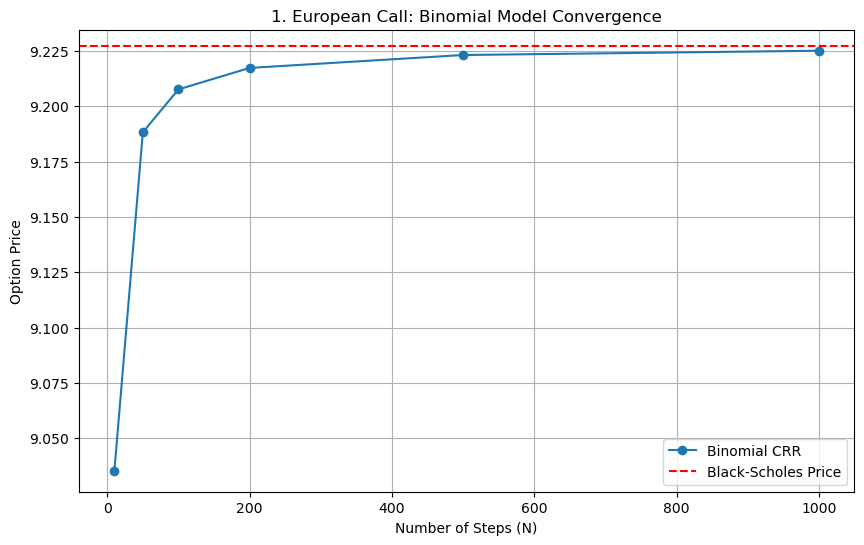

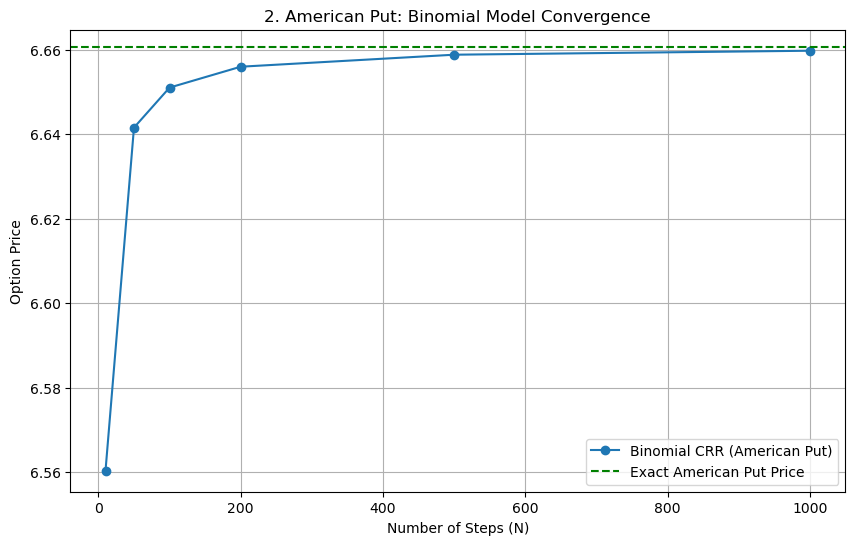

In [10]:
# Black-Scholes for European Call (S0 = 100, K = 100, r = 0.05, q = 0.02, sigma = 0.2, T = 1)
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

bs_call_price = black_scholes_call(S0, K, T, r, q, sigma)

N_values = [10, 50, 100, 200, 500, 1000]
binomial_prices_eur_call = []
errors_eur_call = []

# Calculate binomial prices and errors for European Call
for N in N_values:
    price, _ = binomial_pricer('C', K, T, S0, sigma, r, q, N, 'E')
    binomial_prices_eur_call.append(price)
    errors_eur_call.append(abs(price - bs_call_price))

# Visualization of convergence for European Call
plt.figure(figsize = (10,6))
plt.plot(N_values, binomial_prices_eur_call, 'o-', label = 'Binomial CRR')
plt.axhline(bs_call_price, color = 'red', linestyle = '--', label = 'Black-Scholes Price')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('1. European Call: Binomial Model Convergence')
plt.legend()
plt.grid()
plt.show()

# Convergence analysis for American Put
exact_american_put_price = 6.66069

binomial_prices_am_put = []
errors_am_put = []

# Calculate binomial prices and errors for American Put
for N in N_values:
    price, _ = binomial_pricer('P', K, T, S0, sigma, r, q, N, 'A')
    binomial_prices_am_put.append(price)
    errors_am_put.append(abs(price - exact_american_put_price))

# Visualization of convergence for American Put
plt.figure(figsize = (10,6))
plt.plot(N_values, binomial_prices_am_put, 'o-', label = 'Binomial CRR (American Put)')
plt.axhline(exact_american_put_price, color = 'green', linestyle = '--', label = 'Exact American Put Price')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('2. American Put: Binomial Model Convergence')
plt.legend()
plt.grid()
plt.show()

### Graphs 

Graphs 1 and 2 above show how the binomial CRR model gets closer to the real option price as the number of steps (N) grows. For the European call, the model quickly matches the exact Black-Scholes price. For the American put, it also closely approaches the known correct price. This means my model works well.